## Word embedding : Word2Vec

In this notebook, we will use the Word2Vec model to compute Word Embedding on our tweets dataset, before training a classification model on the lower-dimension vector space.

We will compare this pre-trained cloud model to the baseline model from 1_baseline.ipynb.

### Load project modules and data

We will use basic python packages, and the library package with 300 dimensions of Word2Vec model.

In [1]:
# Import custom helper libraries
import os
import sys
import sys, os, re, csv, codecs
import pickle

# Maths modules
import numpy as np
import pandas as pd
from numpy import exp
from numpy.core.fromnumeric import repeat, shape  # noqa: F401,W0611
from scipy.stats import f_oneway

# Viz modules
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
%matplotlib inline

# Render for export
import plotly.io as pio
pio.renderers.default = "notebook"
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  
import plotly.figure_factory as ff

#Sklearn modules
from sklearn import metrics
from sklearn.metrics import (ConfusionMatrixDisplay,PrecisionRecallDisplay,RocCurveDisplay,)
from sklearn.metrics import (confusion_matrix, roc_auc_score, average_precision_score, classification_report)
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score)
from sklearn.base import ClassifierMixin, is_classifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# System modules
import random
import contractions
import re
import time
from collections import Counter
from collections import defaultdict
from unidecode import unidecode
import logging
from typing import Callable, Dict, List, Optional, Tuple, Union
import gc
from random import shuffle
import itertools

# ML modules
from tqdm import tqdm
tqdm.pandas()

# NLTK modules
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Keras modules
import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, BatchNormalization, TimeDistributed, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
# from keras.layers import (LSTM, Embedding, BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D)
# from keras.optimizers import Adam

# Tensoflow modules
from tensorflow.keras.callbacks import EarlyStopping

# Gensim
import gensim.models.keyedvectors as word2vec

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import session_info
session_info.show()

### Load data
Let's download the data from the [Kaggle - Sentiment140 dataset with 1.6 million tweets competition](https://www.kaggle.com/datasets/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv).

Then, we realized a sampling of the data set to work, during this developmental phase, with 16000 tweets. 

In [79]:
# Load data from CSV
df = pd.read_csv(r"C:\\Users\\ezequ\\proyectos\\openclassrooms\\Projet_7\\data\\raw\\sentiment140_16000_tweets.csv",
                 names=["target", "text"], encoding='latin-1')

# Drop useless raw
df = df.iloc[1: , :]

df.describe(include="all")

,target,text
count,16000,16000
unique,2,15987
top,NEGATIVE,isPlayer Has Died! Sorry
freq,8000,5


### Text pre-processing
Before we can train our model, we need to pre-process the text data. We will tokeinze the text using Keras and vectorize the documents (list of tokens) with the word embedding model FastText.

#### Text tokenization

During the tokenization process, we apply the following pre-processing steps:

* remove special characters
* remove stop words
* lemmatize words
* transform to lowercase

In [80]:
def text_cleaning(text, ponct, only_letters, numbers):
    text = text.lower()
    text = unidecode(text)
    ponctuation = "[^!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]"
    number = "[^0-9]"
    letters = "[^a-zA-Z ]"
    if ponct == 1:
        text = re.sub(ponctuation, '', text)
    if only_letters == 1:
        text = re.sub(letters, '', text)
    if numbers == 1:
        text = re.sub(number, '', text)
    return text

In [81]:
# Let's put the text in lower case.
df["new_text"] = df["text"].str.lower()

In [82]:
# Let's apply the function to write the whole contractions.
df['new_text'] = df.progress_apply(lambda x: contractions.fix(x['text']),axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 38657.31it/s]


In [83]:
# Let's remove the punctuation.
df['new_text'] = df.progress_apply(lambda x: text_cleaning(x['text'], 0, 1, 0),axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 55320.19it/s]


In [84]:
# We can separate the text into word lists => each word unit is a tokens
df['words'] = df.progress_apply(lambda x: word_tokenize(x['new_text']),axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 7780.08it/s]


In [85]:
# Let's count the number of words per comment
df['nb_words'] = df.progress_apply(lambda x: len(x['words']),axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 94386.46it/s]


### Cleaning Stopwords

Let's try to use the nltk library, in order to remove the words that don't bring any information.

In [86]:
nltk.download('stopwords')
sw_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ezequ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
keep_words = []
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

new_sw_nltk.extend(['th','pm', 's', 'er', 'paris', 'rst', 'st', 'am', 'us'])

These words do not bring any meaning regarding the feelings in the sentences. In other words, they are so-called empty words for our project.

In [88]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
cleaning = df['new_text'].str.replace(pat, '')
df['new_words'] = cleaning.progress_apply(lambda x: nltk.word_tokenize(x))
df['new_text'] = cleaning

C:\Users\ezequ\AppData\Local\Temp\ipykernel_77100\2045429064.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 10179.43it/s]


Let's create a function.

In [89]:
# The process of classifying words into their parts of speech and labeling 
# them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. 

def word_pos_tagger(list_words):
    pos_tagged_text = nltk.pos_tag(list_words)
    return pos_tagged_text

Let's concatenate the words of the different documents because we want to see what is the nature of the words in our corpus in order to keep only the useful types.

In [90]:
all_reviews = df["new_text"].str.cat(sep=' ')
description_words = word_pos_tagger(nltk.word_tokenize(all_reviews))

In [91]:
list_keep = []
list_excl = ['IN', 'DT', 'CD', 'CC', 'RP', 'WDT', 'EX', 'MD', 'NNP', 'WDT', 'UH', 'WRB', 
'WP', 'WP$', 'PDT', 'PRP$', 'EX', 'POS', 'SYM', 'TO', 'NNPS']
for word, tag in description_words:
    if tag not in list_excl:
        list_keep.append(tag)

In [92]:
df["text_tokens_pos_tagged"] =  df["new_text"].progress_apply(lambda x: nltk.word_tokenize(x))

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 7768.90it/s]


In [93]:
df["text_tokens_pos_tagged"] =  df["text_tokens_pos_tagged"].progress_apply(lambda x: nltk.pos_tag(x))

100%|███████████████████████████████████████████████████████████████████████████| 16000/16000 [00:17<00:00, 928.78it/s]


Let's arrange the created list

In [94]:
list_nouns = ["NN", "NNS"]
df["words_subjects"] =  df["text_tokens_pos_tagged"].progress_apply(lambda x: [y for y, tag in x if tag in list_nouns])

100%|████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 356505.03it/s]


In [95]:
# The join() method takes all items in an iterable and joins them into one string.
df["words_subjects"] =  df["words_subjects"].progress_apply(lambda x: " ".join(x))

100%|████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 697546.58it/s]


It would also be interesting to **keep the root of the words** after filtering on the names.
There are two methods:

    - Stemming removes suffixes and prefixes from words without taking the context into consideration. 
    - Lemmatization method considers the context and converts the word into its "meaningful" base form.

In [96]:
def stemming_text(word):
    stemmer = SnowballStemmer(language='english')
    return stemmer.stem(word)
 
def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return lemmatizer.lemmatize(text)

In [97]:
df["words_subjects_st"] = df["words_subjects"].progress_apply(lambda x: stemming_text(x))

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 50448.80it/s]


In [98]:
df["words_subjects_lem"] = df["words_subjects"].progress_apply(lambda x: lemmatize_text(x))

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 75318.17it/s]


In [99]:
df["words_token_lem"] = df["words_subjects_lem"].progress_apply(lambda x: word_tokenize(x))

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 12436.26it/s]


In [100]:
df["words_token_st"] = df["words_subjects_st"].progress_apply(lambda x: word_tokenize(x))

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 12834.22it/s]


### Target encoding

In [101]:
le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,text,new_text,words,nb_words,new_words,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,words_token_lem,words_token_st,target_encoded
1,NEGATIVE,@xnausikaax oh no! where did u order from? tha...,xnausikaax oh u order thats horrible,"[xnausikaax, oh, no, where, did, u, order, fro...",10,"[xnausikaax, oh, u, order, thats, horrible]","[(xnausikaax, JJ), (oh, MD), (u, JJ), (order, ...",order thats,order that,order thats,"[order, thats]","[order, that]",0
2,NEGATIVE,A great hard training weekend is over. a coup...,great hard training weekend couple days ...,"[a, great, hard, training, weekend, is, over, ...",25,"[great, hard, training, weekend, couple, days,...","[(great, JJ), (hard, JJ), (training, NN), (wee...",training weekend couple days lets computer time,training weekend couple days lets computer tim,training weekend couple days lets computer time,"[training, weekend, couple, days, lets, comput...","[training, weekend, couple, days, lets, comput...",0
3,NEGATIVE,"Right, off to work Only 5 hours to go until I...",right work hours go im free xd,"[right, off, to, work, only, hours, to, go, un...",12,"[right, work, hours, go, im, free, xd]","[(right, JJ), (work, NN), (hours, NNS), (go, V...",work hours xd,work hours xd,work hours xd,"[work, hours, xd]","[work, hours, xd]",0
4,NEGATIVE,I am craving for japanese food,craving japanese food,"[i, am, craving, for, japanese, food]",6,"[craving, japanese, food]","[(craving, VBG), (japanese, JJ), (food, NN)]",food,food,food,[food],[food],0
5,NEGATIVE,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work...,"[jean, michel, jarre, concert, tomorrow, got, ...",10,"[jean, michel, jarre, concert, tomorrow, got, ...","[(jean, JJ), (michel, NN), (jarre, NN), (conce...",michel jarre concert tomorrow work,michel jarre concert tomorrow work,michel jarre concert tomorrow work,"[michel, jarre, concert, tomorrow, work]","[michel, jarre, concert, tomorrow, work]",0


### Vectorization
#### Word embedding:
    - Glove
    - Word2vec
    - Fasttext
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We will test to diferent techniques to keep the root of eack token. First place, lammelization, and then Steamming. We will try the same model and parameters for both aproaches, to see if there is an impact on the metrics scoring.     

### Lemmatization

In [102]:
list_sentences_train = df["words_subjects_lem"].values
list_sentences_test = df["words_subjects_lem"].values

In [103]:
list_classes = ["target_encoded"]
y = df[list_classes].values

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [104]:
# Calculate the length of our vocabulary
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(list_sentences_train)

In [105]:
word_tokenizer

In [106]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)  + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 18877


In [107]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [108]:
longest_train = max(list_sentences_train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(list_sentences_train), length_long_sentence, padding='post')

In [109]:
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix.

In [110]:
def loadEmbeddingMatrix(typeToLoad):
    """
    Args:
        typeToLoad: word_embedding type
    Returns:
        Embedding_matrix.
    """
    
    
#load different embedding file from Kaggle depending on which embedding 
#matrix we are going to experiment with
    if(typeToLoad=="glove"):
        EMBEDDING_FILE= ('C://Users//ezequ//proyectos//openclassrooms//Projet_7//data//raw//glove.6B.300d.txt')
        embed_size = 300
    elif(typeToLoad=="word2vec"):
#             w2v_model = Word2Vec.load('C://Users//ezequ//proyectos//openclassrooms//Projet_7//data//raw//GoogleNews-vectors-negative300.bin',binary=True,limit=100000)
#             model = w2v_model.wv
        model = word2vec.KeyedVectors.load_word2vec_format('C:\Program Files (x86)\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin',binary=True,limit=100000)
        #model = KeyedVectors.load_word2vec_format('C:\Program Files (x86)\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin',binary=True,limit=100000)
        #word2vec_model =  gensim.models.KeyedVectors.load_word2vec_format('C:\Program Files (x86)\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin', encoding="utf8", binary=True)
        embed_size = 300
    elif(typeToLoad=="fasttext"):
        EMBEDDING_FILE= ('C://Users//ezequ//proyectos//openclassrooms//Projet_7//data//raw//wiki-news-300d-1M.vec')
        embed_size = 300

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
        #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        f = open(EMBEDDING_FILE, encoding="utf8")
        for line in f:
            #split up line into an indexed array
            values = line.split()
            #first index is word
            word = values[0]
            #store the rest of the values in the array as a new array
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs #50 dimensions
        f.close()
        print('Loaded %s word vectors.' % len(embeddings_index))
    else:
        embeddings_index = dict()
        for word in model.key_to_index:
            embeddings_index[word] = model.word_vec(word)
        print('Loaded %s word vectors.' % len(embeddings_index))

    gc.collect()
#We get the mean and standard deviation of the embedding weights so that we could maintain the 
#same statistics for the rest of our own random generated weights. 
    all_embs = np.hstack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(tokenizer.word_index)
#We are going to set the embedding size to the pretrained dimension as we are replicating it.
#the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

#With the newly created embedding matrix, we'll fill it up with the words that we have in both 
#our own dictionary and loaded pretrained embedding. 
    EMBEDDING_DIM = 300
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    embeddedCount = 0
    for word, i in word_index.items():
        i-=1
        #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        #and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')

    del(embeddings_index)
    gc.collect()
    

    #finally, return the embedding matrix
    return embedding_matrix
    

#### Word2vec

Now we load our second embeddings from word2vec

In [111]:
embedding_matrix_word2vec = loadEmbeddingMatrix('word2vec')

C:\Users\ezequ\AppData\Local\Temp\ipykernel_77100\655032971.py:43: DeprecationWarning:

Call to deprecated `word_vec` (Use get_vector instead).



Loaded 100000 word vectors.
total embedded: 5754 common words


In [112]:
embedding_matrix_word2vec.shape

(18877, 300)

In [113]:
maxlen=300
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [114]:
EMBEDDING_DIM = 300

x_word2vec = Embedding(vocab_size,
          EMBEDDING_DIM,
          weights=[embedding_matrix_word2vec],
          input_length=length_long_sentence,
          trainable=False)(inp)


In [115]:
# np.random.shuffle(X_t)
# np.random.shuffle(y)

In [116]:
# Split data into train and test sets
# set aside 20% of train and test data for evaluation
# Manually shuffle the data to avoind val_acc and loss_acc with insignificant values
np.random.shuffle(X_t)
np.random.shuffle(y)

X_train, X_test, y_train, y_test = train_test_split(X_t, y,
    test_size=0.2, shuffle = shuffle, random_state = 42)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.1, random_state= 42) # 0.25 x 0.8 = 0.2

In [117]:
# Print the sets data shapes
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (11520, 300)
X_test shape: (3200, 300)
y_train shape: (11520, 1)
y_test shape: (3200, 1)
X_val shape: (1280, 300)
y_val shape: (1280, 1)


### LSTM Model

In [118]:
def lstm_1():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix_word2vec.shape[0], 
        output_dim=embedding_matrix_word2vec.shape[1], 
        weights = [embedding_matrix_word2vec], 
        input_length=maxlen
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = lstm_1()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          5663100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 130)         190320    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 130)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_2 (Batc  (None, 130)              520       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 130)               0         
                                                      

In [119]:
batch_size = 32
epochs = 10

hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs,  validation_data= [X_val, y_val], callbacks=[EarlyStopping(monitor="val_loss", patience=3),], workers=4,use_multiprocessing=True,)

Epoch 1/10
360/360 [==============================] - 148s 402ms/step - loss: 0.7056 - accuracy: 0.4980 - val_loss: 0.6927 - val_accuracy: 0.5195
Epoch 2/10
360/360 [==============================] - 163s 452ms/step - loss: 0.6960 - accuracy: 0.5109 - val_loss: 0.6991 - val_accuracy: 0.5094
Epoch 3/10
360/360 [==============================] - 171s 474ms/step - loss: 0.6852 - accuracy: 0.5474 - val_loss: 0.7820 - val_accuracy: 0.5164
Epoch 4/10
360/360 [==============================] - 177s 492ms/step - loss: 0.6511 - accuracy: 0.6122 - val_loss: 0.9509 - val_accuracy: 0.4828


In [120]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

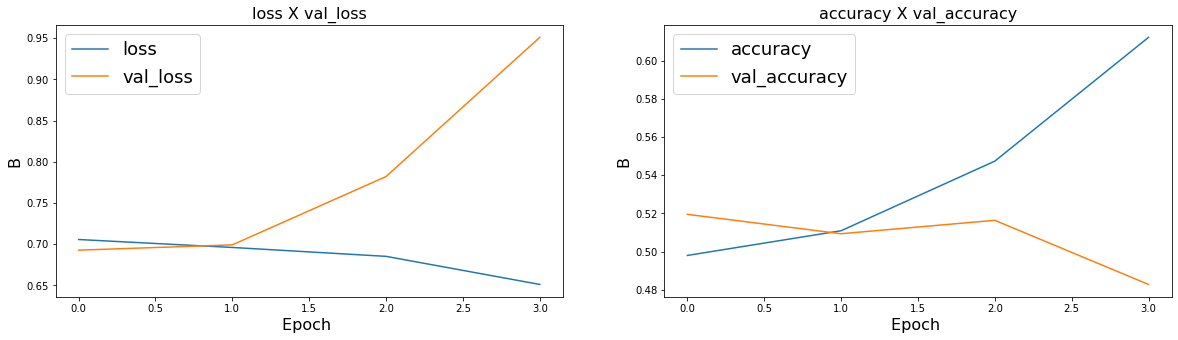

In [121]:
plot(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [122]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

100/100 [==============================] - 10s 100ms/step - loss: 0.9317 - accuracy: 0.4959
Loss: 0.9316652417182922
Accuracy: 0.4959374964237213


In [123]:
x_axes = ['NEGATIVE', 'POSITIVE']
y_axes = ['POSITIVE', 'NEGATIVE']  

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = {},
                      yaxis = {}
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

              precision    recall  f1-score   support

    NEGATIVE       0.50      0.08      0.14       662
    POSITIVE       0.48      0.92      0.63       618

    accuracy                           0.48      1280
   macro avg       0.49      0.50      0.38      1280
weighted avg       0.49      0.48      0.37      1280

ROC AUC score :  0.497
Average Precision score :  0.481


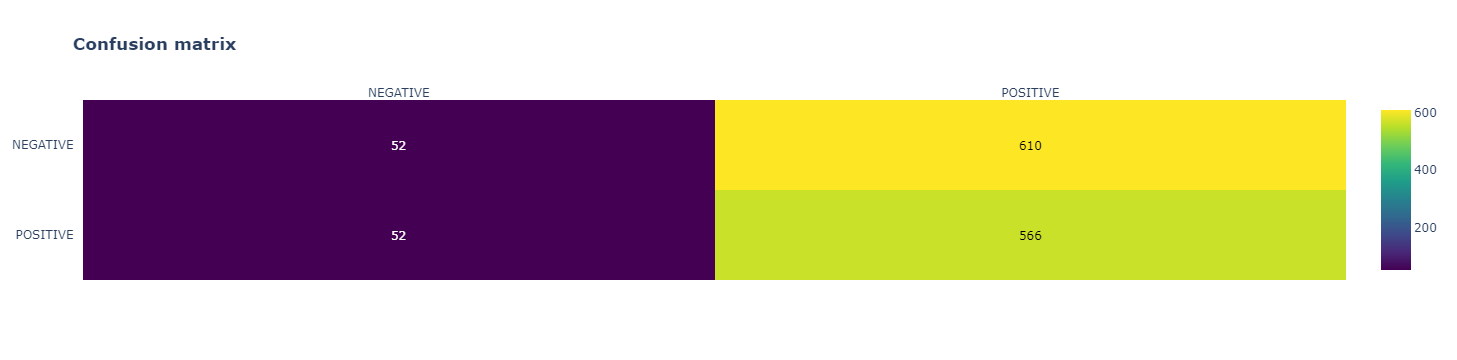

In [124]:
target_names = ['NEGATIVE', 'POSITIVE']
y_preds = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_preds, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(y_val, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_val, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_val, y_preds))

              precision    recall  f1-score   support

    NEGATIVE       0.50      0.07      0.13      1614
    POSITIVE       0.50      0.93      0.65      1586

    accuracy                           0.50      3200
   macro avg       0.50      0.50      0.39      3200
weighted avg       0.50      0.50      0.38      3200

ROC AUC score :  0.5
Average Precision score :  0.495


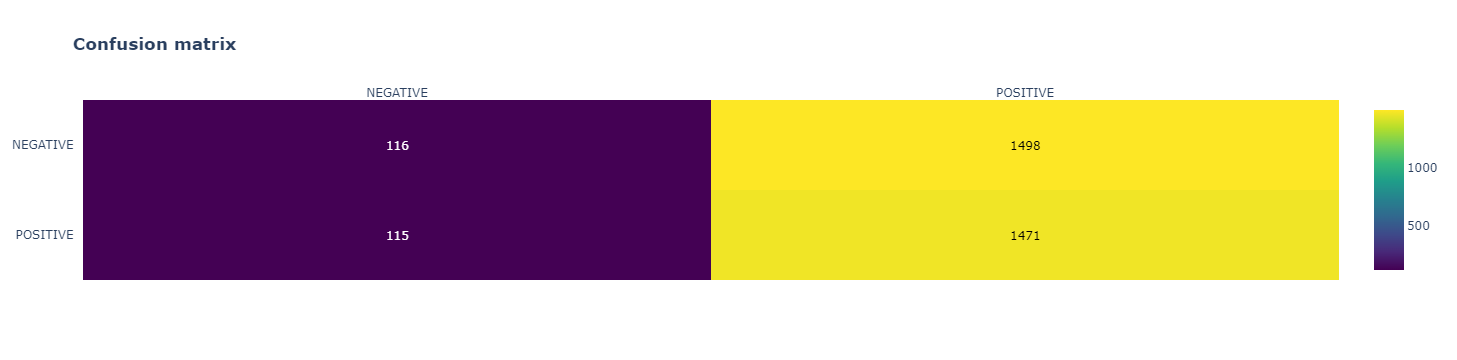

In [125]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_preds, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(y_test, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_test, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

## Steamming testing

The same as before but using steamming 

#### Vectorization

In [126]:
list_classes = ["target_encoded"]
y = df[list_classes].values
embed_size=0

In [127]:
list_sentences_train = df["words_subjects_st"].values
list_sentences_test = df["words_subjects_st"].values

In [128]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [129]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(list_sentences_train)

In [130]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)  + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 19204


In [131]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [132]:
longest_train = max(list_sentences_train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(list_sentences_train), length_long_sentence, padding='post')

In [133]:
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix.

#### Word2vec

In [ ]:
embedding_matrix_word2vec = loadEmbeddingMatrix('word2vec')

C:\Users\ezequ\AppData\Local\Temp\ipykernel_77100\655032971.py:43: DeprecationWarning:

Call to deprecated `word_vec` (Use get_vector instead).



Loaded 100000 word vectors.
total embedded: 5314 common words


In [ ]:
embedding_matrix_word2vec.shape

(19204, 300)

With the embedding weights, we can proceed to build a LSTM layer. The whole architecture is pretty much the same as the previous one I have done in the earlier kernel here, except that I have turned the LSTM into a bidirectional one, and added a dropout factor to it.

We start off with defining our input layer. By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [ ]:
maxlen=300
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [ ]:
EMBEDDING_DIM = 300

x_word2vec = Embedding(vocab_size,
          EMBEDDING_DIM,
          weights=[embedding_matrix_word2vec],
          input_length=length_long_sentence,
          trainable=False)(inp)


#### Model LSTM

In [ ]:
# Split data into train and test sets
# set aside 20% of train and test data for evaluation

X_train, X_test, y_train, y_test = train_test_split(X_t, y,
    test_size=0.2, shuffle = True, random_state = 42)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.1, random_state= 42) # 0.25 x 0.8 = 0.2

In [ ]:
# Print the sets data shapes
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (11520, 300)
X_test shape: (3200, 300)
y_train shape: (11520, 1)
y_test shape: (3200, 1)
X_val shape: (1280, 300)
y_val shape: (1280, 1)


### LSTM Model

In [ ]:
def lstm_1():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix_word2vec.shape[0], 
        output_dim=embedding_matrix_word2vec.shape[1], 
        weights = [embedding_matrix_word2vec], 
        input_length=maxlen
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = lstm_1()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 300)          5761200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 130)         190320    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 130)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_3 (Batc  (None, 130)              520       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 130)               0         
                                                      

In [141]:
batch_size = 32
epochs = 10
# hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs,  validation_data= [X_val, y_val], callbacks=[EarlyStopping(monitor="val_loss", patience=3),], workers=4,use_multiprocessing=True,)

Epoch 1/10
360/360 [==============================] - 185s 505ms/step - loss: 0.6880 - accuracy: 0.5630 - val_loss: 0.6910 - val_accuracy: 0.5148
Epoch 2/10
360/360 [==============================] - 187s 520ms/step - loss: 0.6163 - accuracy: 0.6549 - val_loss: 0.7337 - val_accuracy: 0.6102
Epoch 3/10
360/360 [==============================] - 182s 505ms/step - loss: 0.5372 - accuracy: 0.7302 - val_loss: 0.6871 - val_accuracy: 0.6383
Epoch 4/10
360/360 [==============================] - 190s 528ms/step - loss: 0.4283 - accuracy: 0.8043 - val_loss: 0.7484 - val_accuracy: 0.6273
Epoch 5/10
360/360 [==============================] - 185s 515ms/step - loss: 0.3251 - accuracy: 0.8569 - val_loss: 0.8680 - val_accuracy: 0.6141
Epoch 6/10
360/360 [==============================] - 181s 503ms/step - loss: 0.2624 - accuracy: 0.8916 - val_loss: 0.8903 - val_accuracy: 0.6211


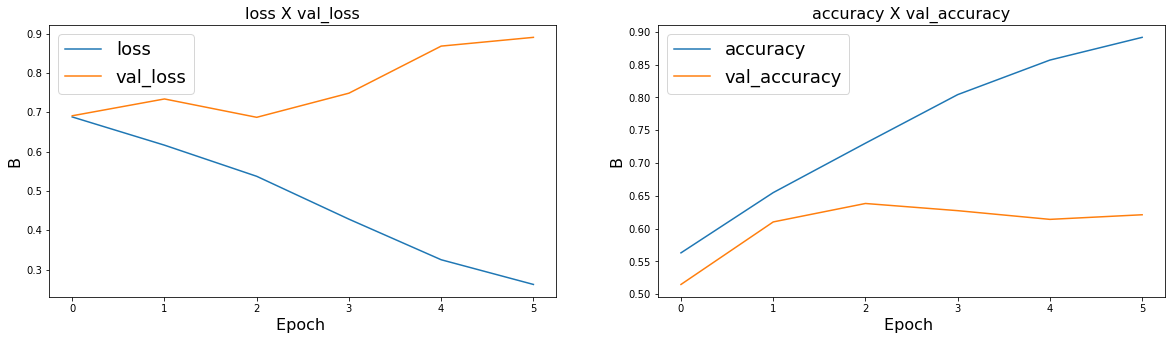

In [142]:
plot(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [143]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

100/100 [==============================] - 10s 99ms/step - loss: 0.8226 - accuracy: 0.6434
Loss: 0.8226268291473389
Accuracy: 0.6434375047683716


              precision    recall  f1-score   support

    NEGATIVE       0.65      0.51      0.57       633
    POSITIVE       0.60      0.73      0.66       647

    accuracy                           0.62      1280
   macro avg       0.63      0.62      0.62      1280
weighted avg       0.63      0.62      0.62      1280

ROC AUC score :  0.62
Average Precision score :  0.577


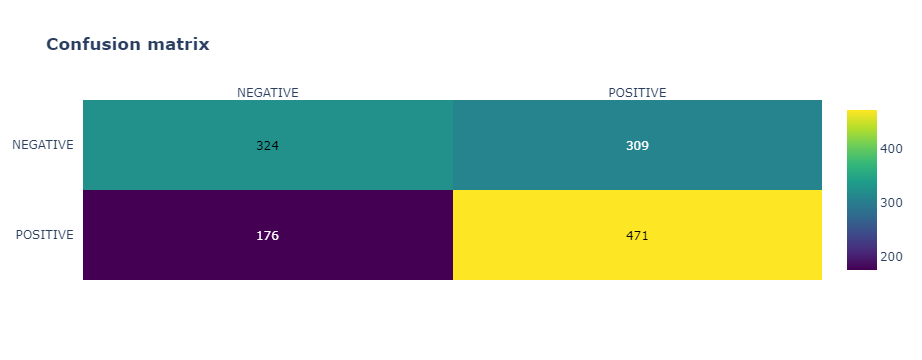

In [144]:
y_preds = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_preds, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(y_val, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_val, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_val, y_preds))

              precision    recall  f1-score   support

    NEGATIVE       0.68      0.55      0.61      1604
    POSITIVE       0.62      0.74      0.67      1596

    accuracy                           0.64      3200
   macro avg       0.65      0.64      0.64      3200
weighted avg       0.65      0.64      0.64      3200

ROC AUC score :  0.644
Average Precision score :  0.588


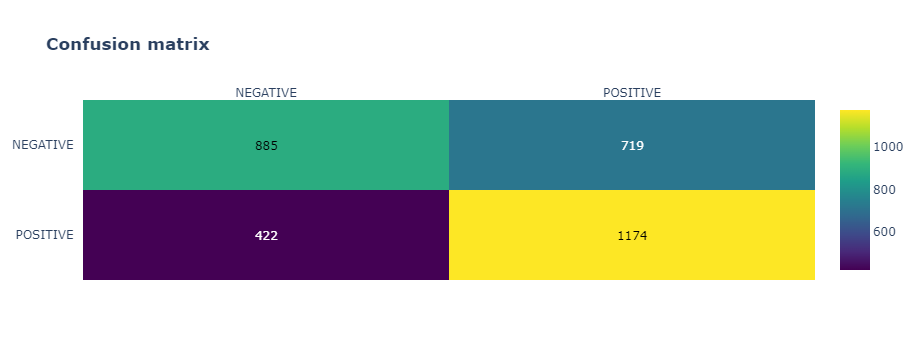

In [145]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_preds, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(y_test, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_test, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

### Conclusions
The performances on the dataset are slightly worst than our baseline model :

**Lemm + Word2Vec + LSTM**

* Average Precision = 0.495(baseline = 0.64 , -23.8%)
* ROC AUC = 0.5 (baseline = 0.65 , -23.07%)

**Steamm + Word2Vec + LSTM**

* Average Precision = 0.577 (baseline = 0.65 , -12.5%)
* ROC AUC = 0.62 (baseline = 0.66 , -6.06%)

Our model is also biased towards the POSITIVE.